# ADDA for ST

Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
from math import ceil
import glob
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

import scipy.stats as ss
from scipy.sparse import csr_matrix
import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch.nn import functional as F
from torch import nn

import datetime

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
results_folder = os.path.join('results', script_start_time)
model_folder = os.path.join('model', script_start_time)

model_folder = os.path.join('model', 'TESTING')

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

In [4]:
num_markers = 20
n_mix = 8
n_spots = 20000

sample_id_n = 151673

batch_size = 1024
num_workers = 8
initial_train_epochs = 100


min_epochs = 0.4 * initial_train_epochs
early_stop_crit = initial_train_epochs


# Define model components

In [5]:
class MLPEncoder(nn.Module):
    def __init__(self, inp_dim, emb_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 1024), 
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.99), 
            nn.ELU(),

            nn.Linear(1024, emb_dim), 
            nn.BatchNorm1d(emb_dim, eps=0.001, momentum=0.99), 
            nn.ELU()
        )

    def forward(self, x):
        return self.encoder(x)

In [6]:
class Classifier(nn.Module):
    def __init__(self, emb_dim, ncls_source):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, ncls_source), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.head(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, 32), 
            nn.BatchNorm1d(32, eps=0.001, momentum=0.99), 
            nn.ELU(), 
            
            nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.head(x)

In [8]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [9]:
class ADDAST(nn.Module):
    def __init__(self, inp_dim, emb_dim, ncls_source):
        super().__init__()

        self.source_encoder = MLPEncoder(inp_dim, emb_dim)
        self.target_encoder = MLPEncoder(inp_dim, emb_dim)
        self.clf = Classifier(emb_dim, ncls_source)
        self.dis = Discriminator(emb_dim)

        self.is_encoder_source = True

    def forward(self, x):
        if self.is_encoder_source:
            x = self.source_encoder(x)
        else:
            x = self.target_encoder(x)

        x = self.clf(x)

        return x

    def pretraining(self):
        self.is_encoder_source = True
        set_requires_grad(self.source_encoder, True)
        set_requires_grad(self.clf, True)

    def advtraining(self, train_dis=True):
        set_requires_grad(self.source_encoder, False)

        if train_dis:
            self.train_discriminator()
        else:
            self.train_target_encoder()

    def target_inference(self):
        self.is_encoder_source = False

    def train_discriminator(self):
        set_requires_grad(self.target_encoder, False)
        set_requires_grad(self.dis, True)

    def train_target_encoder(self):
        set_requires_grad(self.target_encoder, True)
        set_requires_grad(self.dis, False)

    def set_encoder(self, encoder="source"):
        if encoder == "source":
            self.is_encoder_source = True
        elif encoder == 'target':
            self.is_encoder_source = False
        else:
            current_encoder_str = '\'source\'' if self.is_encoder_source else '\'target\''
            warnings.warn(
                f"encoder parameter should be 'source' or 'target', got {encoder}; encoder is currently {current_encoder_str}",
                RuntimeWarning
            )


In [10]:
class SpotDataset(torch.utils.data.Dataset):
    """Dataset for cell spots. Returns a spot with GEx data, and optionally cell type distribution"""
    def __init__(self, X, Y=None):
        """
        Args:
            X (array_like of rank 2): An (n_spots, n_genes) array of normalized log gene expression values.
            Y (array_like of rank 2, optional): An (n_spots, n_cell_types) array of cell type distribution.
        """
        super().__init__()

        self.X = torch.as_tensor(X).float()
        assert self.X.dim() == 2, f"X should be rank 2, got {self.X.dim()}"

        if Y is None:
            self.Y = Y
        else:
            self.Y = torch.as_tensor(Y).float()
            assert self.Y.dim() == 2, f"Y should be rank 2, got {self.Y.dim()}"
            assert len(self.X) == len(self.Y), "X and Y unequal lengths"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.Y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.Y[idx]


# Prepare Data
## Data load
### Load SpatialLIBD Data

In [11]:
spatialLIBD_dir = './data/spatialLIBD'

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(spatialLIBD_dir, 'adata')

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, 'adata_spatialLIBD-*.h5ad')):
    sample_id = int(name.partition("-")[2].rpartition(".")[0])
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplo

### Load Single Cell Data

In [12]:
adata_sc_dlpfc = sc.read_h5ad('./data/sc_dlpfc/adata_sc_dlpfc.h5ad')
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e6)
adata_sc_dlpfc.var_names_make_unique()

## Find Marker Genes

In [13]:
#Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])

In [14]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')

In [15]:
df_genelists = pd.read_pickle('data/sc_dlpfc/df_genelists.pkl')
res_genes = []
for column in df_genelists.head(num_markers):
    res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(res_genes))

# with open('data/res_genes_.json', 'w') as f:
#     json.dump(res_genes_, f)

### Select same gene features 

In [16]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), 
    label='sample_id', 
    keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e6)


/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print('Selected Feature Gene number', len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 362


## Format Data

In [18]:
mat_sc = adata_sc_dlpfc.X.todense()
mat_sp_train = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == sample_id_n].X.todense()
# mat_sp_train = adata_spatialLIBD.X.todense()
mat_sp_test = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == sample_id_n].X.todense()

df_sc = adata_sc_dlpfc.obs

lab_sc_sub = df_sc.cell_subclass
sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype='int')

## Generate Pseudospots

In [19]:
from sklearn.preprocessing import OneHotEncoder


def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    # Define empty lists
    Xs_new, ys_new = [], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples, nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction / np.sum(fraction)
        fraction = np.reshape(fraction, (nmix, 1))

        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix * fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex]) * fraction
        XX_ = np.sum(XX, axis=0)

        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        Xs_new.append(XX_)

    Xs_new = np.asarray(Xs_new)
    ys_new = np.asarray(ys_new)

    return Xs_new, ys_new

## Generate Pseudospots

In [20]:
mat_sc_train, mat_sc_eval, lab_sc_num_train, lab_sc_num_eval = train_test_split(
    mat_sc, 
    lab_sc_num, 
    test_size=0.2, 
    random_state=225, 
    stratify=lab_sc_num
)

mat_sc_val, mat_sc_test, lab_sc_num_val, lab_sc_num_test = train_test_split(
    mat_sc_eval,
    lab_sc_num_eval,
    test_size=0.5,
    random_state=263,
    stratify=lab_sc_num_eval
)

sc_mix_train, lab_mix_train = random_mix(
    mat_sc_train, lab_sc_num_train, nmix=n_mix, n_samples=n_spots
)
sc_mix_val, lab_mix_val = random_mix(
    mat_sc_val, lab_sc_num_val, nmix=n_mix, n_samples=n_spots // 8
)
sc_mix_test, lab_mix_test = random_mix(
    mat_sc_test, lab_sc_num_test, nmix=n_mix, n_samples=n_spots // 8
)


def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)

    min2max = np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))
    arr_minus_min = (arr - np.reshape(np.min(arr, axis=1), (arrd, 1)))
    return arr_minus_min / min2max


sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_val_s = log_minmaxscale(sc_mix_val)
sc_mix_test_s = log_minmaxscale(sc_mix_test)

mat_sp_train_s = log_minmaxscale(mat_sp_train)
# mat_sp_val_s = log_minmaxscale(mat_sp_val)
mat_sp_test_s = log_minmaxscale(mat_sp_test)
mat_sc_s = log_minmaxscale(mat_sc)

In [21]:
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

target_train_set = SpotDataset(mat_sp_train_s)
target_test_set = SpotDataset(mat_sp_test_s)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

dataloader_target_train = torch.utils.data.DataLoader(
    target_train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)
dataloader_target_test = torch.utils.data.DataLoader(
    target_test_set, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)


# Training: Adversarial domain adaptation for cell fraction estimation

## Define Model

In [22]:
model = ADDAST(
    sc_mix_train_s.shape[1], 
    emb_dim=64, 
    ncls_source=lab_mix_train.shape[1]
)

model.to(device)

ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Lo

## Pretrain

In [23]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)

In [24]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.002, 
    betas=(0.9, 0.999), 
    eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer, 
    max_lr=0.002, 
    steps_per_epoch=len(dataloader_source_train), 
    epochs=initial_train_epochs
)

criterion = nn.KLDivLoss(reduction="batchmean")

In [25]:
# from copy import deepcopy

# from ignite.handlers import FastaiLRFinder

# checkpoint_0 = {
#     "model": deepcopy(model.state_dict()),
#     "pre_optimizer": deepcopy(pre_optimizer.state_dict())
# }

In [26]:
model.pretraining()

In [27]:
def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):

            x = x.to(torch.float32).to(device)
            y_true = y_true.to(torch.float32).to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y_true)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights)

In [28]:
from tqdm.autonotebook import tqdm

# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

# Train
print("Start pretrain...")
outer = tqdm(total=initial_train_epochs, desc='Epochs', position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f'Batch', position=1)
for epoch in range(initial_train_epochs):

    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epoch > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = {
            'epoch': epoch,
            'model': model,
            'pre_optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(
            checkpoint,
            os.path.join(pretrain_folder, f'checkpt_earlystop_{epoch}.pth')
        )
        break

    early_stop_count += 1

    #Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  #force print final state
    inner.reset()  #reuse bar
    for _, (x, y_true) in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        x = x.to(torch.float32).to(device)
        y_true = y_true.to(torch.float32).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y_true)

        loss_running.append(loss.item())

        # we will weight average by batch size later
        mean_weights.append(len(x))

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        # Change the learning rate
        pre_scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))

    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = {
            'epoch': epoch,
            'model': model,
            'optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f'best_model.pth'))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= initial_train_epochs - 1:
        checkpoint = {
            'epoch': epoch,
            'model': model,
            'pre_optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(
            checkpoint, os.path.join(pretrain_folder, f'checkpt{epoch}.pth')
        )

    # Print the results
    outer.update(1)
    print(
        "epoch:", epoch, \
        "train loss:", round(loss_history[-1], 6), \
        "validation loss:", round(loss_history_val[-1], 6), \
        # "next_lr:", scheduler.get_last_lr(),






    )

# Save final model
checkpoint = {
    'epoch': epoch,
    'model': model,
    'pre_optimizer': pre_optimizer,
    # 'scheduler': scheduler,
    # 'scaler': scaler
}
torch.save(checkpoint, os.path.join(pretrain_folder, f'final_model.pth'))

Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 train loss: 1.764099 validation loss: 1.575787
epoch: 1 train loss: 1.498828 validation loss: 1.437312
epoch: 2 train loss: 1.389318 validation loss: 1.355409
epoch: 3 train loss: 1.313956 validation loss: 1.302092
epoch: 4 train loss: 1.251074 validation loss: 1.227169
epoch: 5 train loss: 1.190455 validation loss: 1.18647
epoch: 6 train loss: 1.128373 validation loss: 1.134136
epoch: 7 train loss: 1.06305 validation loss: 1.057699
epoch: 8 train loss: 0.993223 validation loss: 0.9772
epoch: 9 train loss: 0.920021 validation loss: 0.923506
epoch: 10 train loss: 0.845554 validation loss: 0.872297
epoch: 11 train loss: 0.772031 validation loss: 0.782156
epoch: 12 train loss: 0.703847 validation loss: 0.714567
epoch: 13 train loss: 0.647179 validation loss: 0.709158
epoch: 14 train loss: 0.605619 validation loss: 0.70726
epoch: 15 train loss: 0.575405 validation loss: 0.719255
epoch: 16 train loss: 0.554876 validation loss: 0.668235
epoch: 17 train loss: 0.53642 validation loss:

## Adversarial Adaptation

In [133]:
best_checkpoint = torch.load(os.path.join(pretrain_folder, f'best_model.pth'))
model = best_checkpoint['model']
model.to(device)

model.advtraining()

In [134]:
def cycle_iter(iter):
    while True:
        yield from iter


In [135]:
n_iter = 3000
epochs = 50
alpha_lr = 5

advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)

criterion = nn.CrossEntropyLoss()

target_optimizer = torch.optim.Adam(
    model.target_encoder.parameters(),
    lr=0.0005,
    betas=(0.9, 0.999),
    eps=1e-07
)

dis_optimizer = torch.optim.Adam(
    model.dis.parameters(), 
    lr=0.00025, 
    betas=(0.9, 0.999), 
    eps=1e-07
)

iters = max(len(dataloader_source_train), len(dataloader_target_train))

dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    dis_optimizer, 
    max_lr=0.0005, 
    steps_per_epoch=iters, 
    epochs=epochs
)
target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    target_optimizer, 
    max_lr=0.0005, 
    steps_per_epoch=iters, 
    epochs=epochs
)


min_epochs_adv = 0.4 * epochs
early_stop_crit_adv = epochs


In [136]:
p = len(source_train_set) / (len(source_train_set) + len(target_train_set))
rand_loss = -(p * np.log(0.5)) - (1 - p) * np.log(0.5)

In [137]:
# from tqdm.autonotebook import tqdm

# # Initialize lists to store loss and accuracy values
# loss_history_running = []

# batch_cycler_s = cycle_iter(dataloader_source_train)
# batch_cycler_t = cycle_iter(dataloader_target_train)

# # Train
# print("Start adversarial training...")
# outer = tqdm(total=n_iter, desc='Iterations', position=0)

# #Train mode
# model.train()
# model.dis.train()
# model.target_encoder.train()

# model.advtraining()

# loss_running = []
# accu_running = []
# mean_weights = []

# for iters in range(n_iter):
#     model.train_discriminator()

#     x_source, _ = next(batch_cycler_s)
#     x_target = next(batch_cycler_t)
#     x_source, x_target = x_source.to(device), x_target.to(device)

#     dis_optimizer.zero_grad()
#     y_dis = torch.cat(
#         [
#             torch.ones(x_source.shape[0], device=device, dtype=torch.long),
#             torch.zeros(x_target.shape[0], device=device, dtype=torch.long)
#         ]
#     )

#     emb_source = model.source_encoder(x_source).view(x_source.shape[0], -1)
#     emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)

#     emb_all = torch.cat((emb_source, emb_target))

#     y_pred = model.dis(emb_all)

#     loss = criterion(y_pred, y_dis)
#     loss_running.append(loss.item())
#     accu_running.append(
#         torch.mean(
#             (torch.flatten(torch.argmax(y_pred,
#                                         dim=1)) == y_dis).to(torch.float32)
#         )
#     )
#     # we will weight average by batch size later
#     mean_weights.append(len(y_dis))

#     # scaler.scale(loss).backward()
#     # scaler.step(optimizer)
#     # scaler.update()

#     loss.backward()
#     dis_optimizer.step()

#     model.train_target_encoder()

#     x_target = next(batch_cycler_t)
#     x_target = x_target.to(device)

#     target_optimizer.zero_grad()
#     # flip label
#     y_dis = torch.ones(x_target.shape[0], device=device, dtype=torch.long)

#     emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)
#     y_pred = model.dis(emb_target)
#     loss = criterion(y_pred, y_dis)

#     loss.backward()
#     target_optimizer.step()

#     # Save checkpoint every 100
#     if iters % 100 == 99 or iters >= n_iter - 1:
#         checkpoint = {
#             'epoch': iters,
#             'model': model,
#             'dis_optimizer': dis_optimizer,
#             'target_optimizer': target_optimizer,

#             # 'scheduler': scheduler,
#             # 'scaler': scaler
#         }
#         torch.save(
#             checkpoint, os.path.join(advtrain_folder, f'checkpt{iters}.pth')
#         )


#         accu_running[-100:] = [x.cpu() for x in accu_running[-100:]]

#         # Print the results
#         print(
#             "iter:", iters, \
#             "dis loss:", round(np.average(loss_running[-100:], weights=mean_weights[-100:]), 6), \
#             "dis accu:", round(np.average(accu_running[-100:], weights=mean_weights[-100:]), 6), \
#             # "next_lr:", scheduler.get_last_lr(),

#         )

#     outer.update(1)

# # Save final model

# checkpoint = {
#     'epoch': n_iter,
#     'model': model,
#     'dis_optimizer': dis_optimizer,
#     'target_optimizer': target_optimizer,

#     # 'scheduler': scheduler,
#     # 'scaler': scaler
# }

# torch.save(checkpoint, os.path.join(advtrain_folder, f'final_model.pth'))

In [138]:
from tqdm.autonotebook import tqdm

# Initialize lists to store loss and accuracy values
loss_history = []
accu_history = []
loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

batch_cycler = zip(cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train))

# Train
print("Start adversarial training...")
print("Discriminator target loss:", rand_loss)
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner1 = tqdm(total=iters, desc=f'Batch (Discriminator)', position=1)
inner2 = tqdm(total=iters, desc=f'Batch (Encoder)', position=2)
for epoch in range(epochs):

    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit_adv and epoch > min_epochs_adv:
        print(f'Discriminator loss plateaud; failed to get worse after {early_stop_count} at {epoch}th epoch')
        checkpoint = {
            'epoch': epochs,
            'model': model,
            'dis_optimizer': dis_optimizer,
            'target_optimizer': target_optimizer,

            # 'dis_scheduler': dis_scheduler,
            # 'target_scheduler': target_scheduler,
            # # 'scaler': scaler
        }
        torch.save(
            checkpoint,
            os.path.join(advtrain_folder, f'checkpt_earlystop_{epoch}.pth')
        )
        break

    early_stop_count += 1

    #Train mode
    model.train()
    
    


    loss_running = []
    accu_running = []
    mean_weights = []

    model.train_discriminator()
    model.target_encoder.eval()
    model.source_encoder.eval()
    model.dis.train()

    inner1.refresh()  #force print final state
    inner1.reset()  #reuse bar
    inner2.refresh()  #force print final state
    inner2.reset()  #reuse bar
    for _ in range(iters):
        # lr_history_running.append(scheduler.get_last_lr())

        # for iters in range(n_iter):

        (x_source, _), (x_target) = next(batch_cycler)
        x_source, x_target = x_source.to(device), x_target.to(device)

        dis_optimizer.zero_grad()
        y_dis = torch.cat(
            [
                torch.ones(x_source.shape[0], device=device, dtype=torch.long),
                torch.zeros(x_target.shape[0], device=device, dtype=torch.long)
            ]
        )

        emb_source = model.source_encoder(x_source).view(x_source.shape[0], -1)
        emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)

        emb_all = torch.cat((emb_source, emb_target))

        y_pred = model.dis(emb_all)

        #     # we will weight average by batch size later
        mean_weights.append(len(y_dis))

        #     # scaler.scale(loss).backward()
        #     # scaler.step(optimizer)
        #     # scaler.update()

        loss = criterion(y_pred, y_dis)
        loss_running.append(loss.item())
        accu_running.append(
            torch.mean(
                (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(torch.float32)
            )
        )

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        dis_optimizer.step()
        dis_scheduler.step()

        inner1.update(1)

    accu_running = [x.cpu() for x in accu_running]

    loss_history.append(np.average(loss_running, weights=mean_weights))
    accu_history.append(np.average(accu_running, weights=mean_weights))

    loss_history_running.append(loss_running)

    model.train_target_encoder()
    model.target_encoder.train()
    model.source_encoder.eval()
    model.dis.eval()
    for _ in range(iters):
        _, x_target = next(batch_cycler)
        x_target = x_target.to(device)

        target_optimizer.zero_grad()

        # flip label
        y_dis = torch.ones(x_target.shape[0], device=device, dtype=torch.long)

        emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)
        y_pred = model.dis(emb_target)
        loss = criterion(y_pred, y_dis)

        loss.backward()
        target_optimizer.step()
        target_scheduler.step()

        inner2.update(1)

    # Save the best weights
    if math.fabs(loss_history[-1] - rand_loss) < best_loss_val:
        best_loss_val = math.fabs(loss_history[-1] - rand_loss)
        checkpoint = {
            'epoch': iters,
            'model': model,
            'dis_optimizer': dis_optimizer,
            'target_optimizer': target_optimizer,

            # 'dis_scheduler': dis_scheduler,
            # 'target_scheduler': target_scheduler,
        }
        torch.save(checkpoint, os.path.join(advtrain_folder, f'best_model.pth'))

        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= epochs - 1:
        checkpoint = {
            'epoch': iters,
            'model': model,
            'dis_optimizer': dis_optimizer,
            'target_optimizer': target_optimizer,

            # 'dis_scheduler': dis_scheduler,
            # 'target_scheduler': target_scheduler,
        }
        torch.save(
            checkpoint, os.path.join(advtrain_folder, f'checkpt{iters}.pth')
        )

    # Print the results
    outer.update(1)
    print(
        "epoch:", epoch, \
        "dis loss:", round(loss_history[-1], 6), \
        "dis accu:", round(accu_history[-1], 6), \
        "difference from random loss:", round(math.fabs(loss_history[-1] - rand_loss), 6)
        # "next_lr:", scheduler.get_last_lr(),
    )

# Save final model
checkpoint = {
    'epoch': iters,
    'model': model,
    'dis_optimizer': dis_optimizer,
    'target_optimizer': target_optimizer,

    # 'dis_scheduler': dis_scheduler,
    # 'target_scheduler': target_scheduler,
}
torch.save(checkpoint, os.path.join(advtrain_folder, f'final_model.pth'))

Start adversarial training...
Discriminator target loss: 0.6931471805599453


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.814191 dis accu: 0.580652 difference from random loss: 0.121044
epoch: 1 dis loss: 0.828559 dis accu: 0.478701 difference from random loss: 0.135412
epoch: 2 dis loss: 0.848382 dis accu: 0.461867 difference from random loss: 0.155235
epoch: 3 dis loss: 0.86088 dis accu: 0.445948 difference from random loss: 0.167733
epoch: 4 dis loss: 0.847013 dis accu: 0.453358 difference from random loss: 0.153866
epoch: 5 dis loss: 0.815173 dis accu: 0.49119 difference from random loss: 0.122026
epoch: 6 dis loss: 0.771032 dis accu: 0.542741 difference from random loss: 0.077885
epoch: 7 dis loss: 0.723888 dis accu: 0.593402 difference from random loss: 0.03074
epoch: 8 dis loss: 0.635318 dis accu: 0.692447 difference from random loss: 0.057829
epoch: 9 dis loss: 0.561296 dis accu: 0.759497 difference from random loss: 0.131852
epoch: 10 dis loss: 0.53463 dis accu: 0.78649 difference from random loss: 0.158517
epoch: 11 dis loss: 0.464213 dis accu: 0.832962 difference from rando

# 4. Predict cell fraction of spots and visualization

In [139]:
best_checkpoint = torch.load(os.path.join(advtrain_folder, f'best_model.pth'))
model = best_checkpoint['model']
model.to(device)

ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Lo

In [140]:
model.eval()
model.target_inference()

pred_sp = F.softmax(model(torch.Tensor(mat_sp_test_s).to(device)), dim=1).detach().cpu().numpy()
adata_spatialLIBD_151673 =  adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == 151673]

adata_spatialLIBD_151673.obsm['spatial'] = adata_spatialLIBD_151673.obs[['X','Y']].values

In [141]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if 'Ex' in v:
        num_name_exN_l.append((k, v, int(v.split('_')[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l

[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [142]:
Ex_to_L_d = {
    1 : {5,6},
    2 : {5},
    3 : {4,5},
    4 : {6},
    5 : {5},
    6 : {4,5,6},
    7 : {4,5,6},
    8 : {5,6},
    9 : {5,6},
    10: {2,3,4}
}

In [143]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))

In [144]:
def plot_cellfraction(visnum, ax=None):
    adata_spatialLIBD_151673.obs['Pred_label'] = pred_sp[:,visnum]
    vmin = 0
    vmax = np.amax(pred_sp)
    

    sc.pl.spatial(
        adata_spatialLIBD_151673,
        img_key="hires",
        color='Pred_label',
        palette='Set1',
        size=1.5,
        legend_loc=None,
        title = f'{sc_sub_dict[visnum]} 151673',
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax)

In [145]:
def plot_cell_layers(df):
    
    layer_idx = df["spatialLIBD"].unique().astype(str)
    samples = df["sample_id"].unique()
    layer_idx.sort()
    fig, ax = plt.subplots(nrows = 1, ncols = len(samples), figsize = (5*len(samples),5), squeeze=False, constrained_layout=True)


    
    for idx, sample in enumerate(samples):
        cells_of_samples = df[df["sample_id"] == sample]
        for index in layer_idx:
            cells_of_layer = cells_of_samples[cells_of_samples["spatialLIBD"] == index]
            ax.flat[idx].scatter(cells_of_layer["X"], -cells_of_layer["Y"], label = index, s=17, marker='o')
        
        ax.flat[idx].axis('equal')
        ax.flat[idx].set_xticks([])
        ax.flat[idx].set_yticks([])
        ax.flat[idx].set_title(sample)
        
    plt.legend()
    plt.show()



In [146]:
from sklearn.metrics import RocCurveDisplay




def plot_roc(visnum, ax=None):
    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0
    y_pred =  pred_sp[:,visnum]
    y_true = adata_spatialLIBD_151673.obs['spatialLIBD'].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        name = 'CellDART',
        ax = ax
    )
    


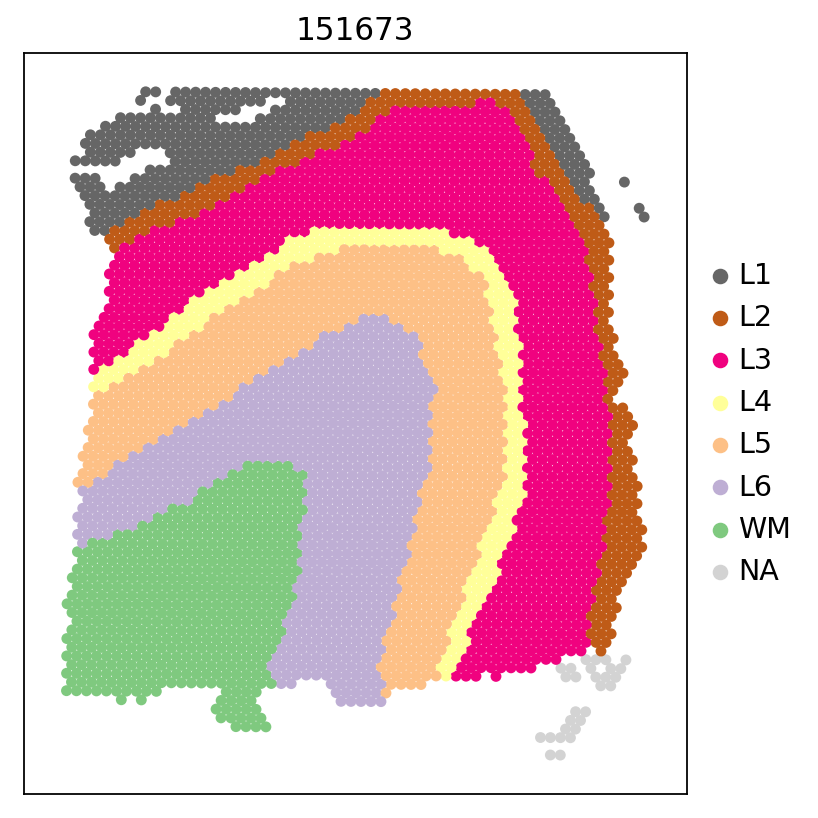

In [147]:
# plot_cell_layers(adata_spatialLIBD_151673.obs)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_151673,
    img_key=None,
    color="spatialLIBD",
    palette='Accent_r',
    size=1.5,
    title = f'151673',
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax)

ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')

fig.show()

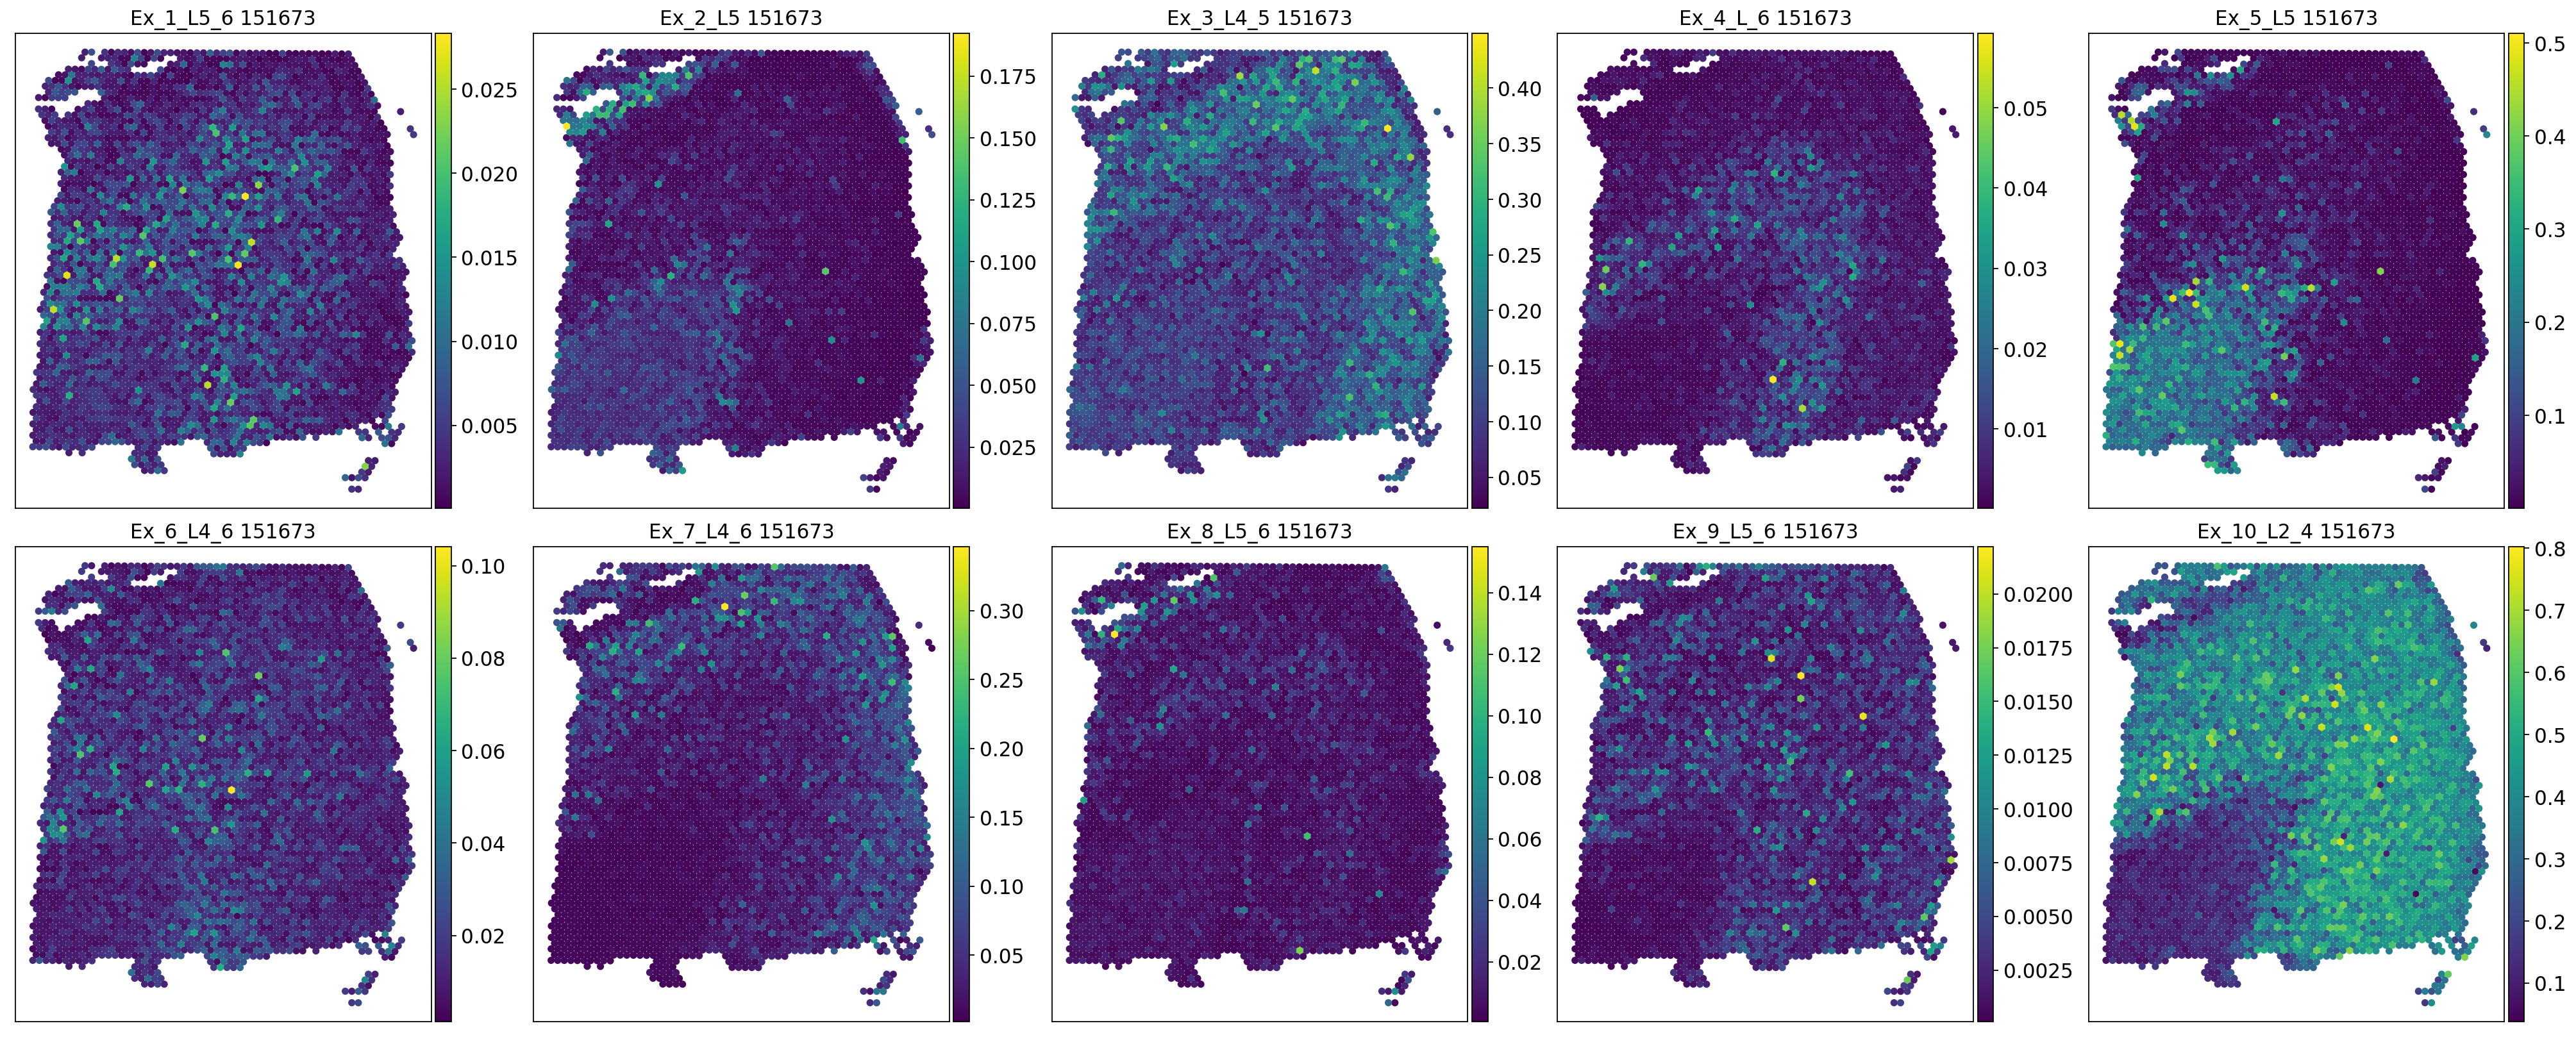

In [148]:
fig, ax = plt.subplots(2, 5, figsize=(25,10), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(num, ax.flat[i])
    ax.flat[i].axis('equal')
    ax.flat[i].set_xlabel('')
    ax.flat[i].set_ylabel('')

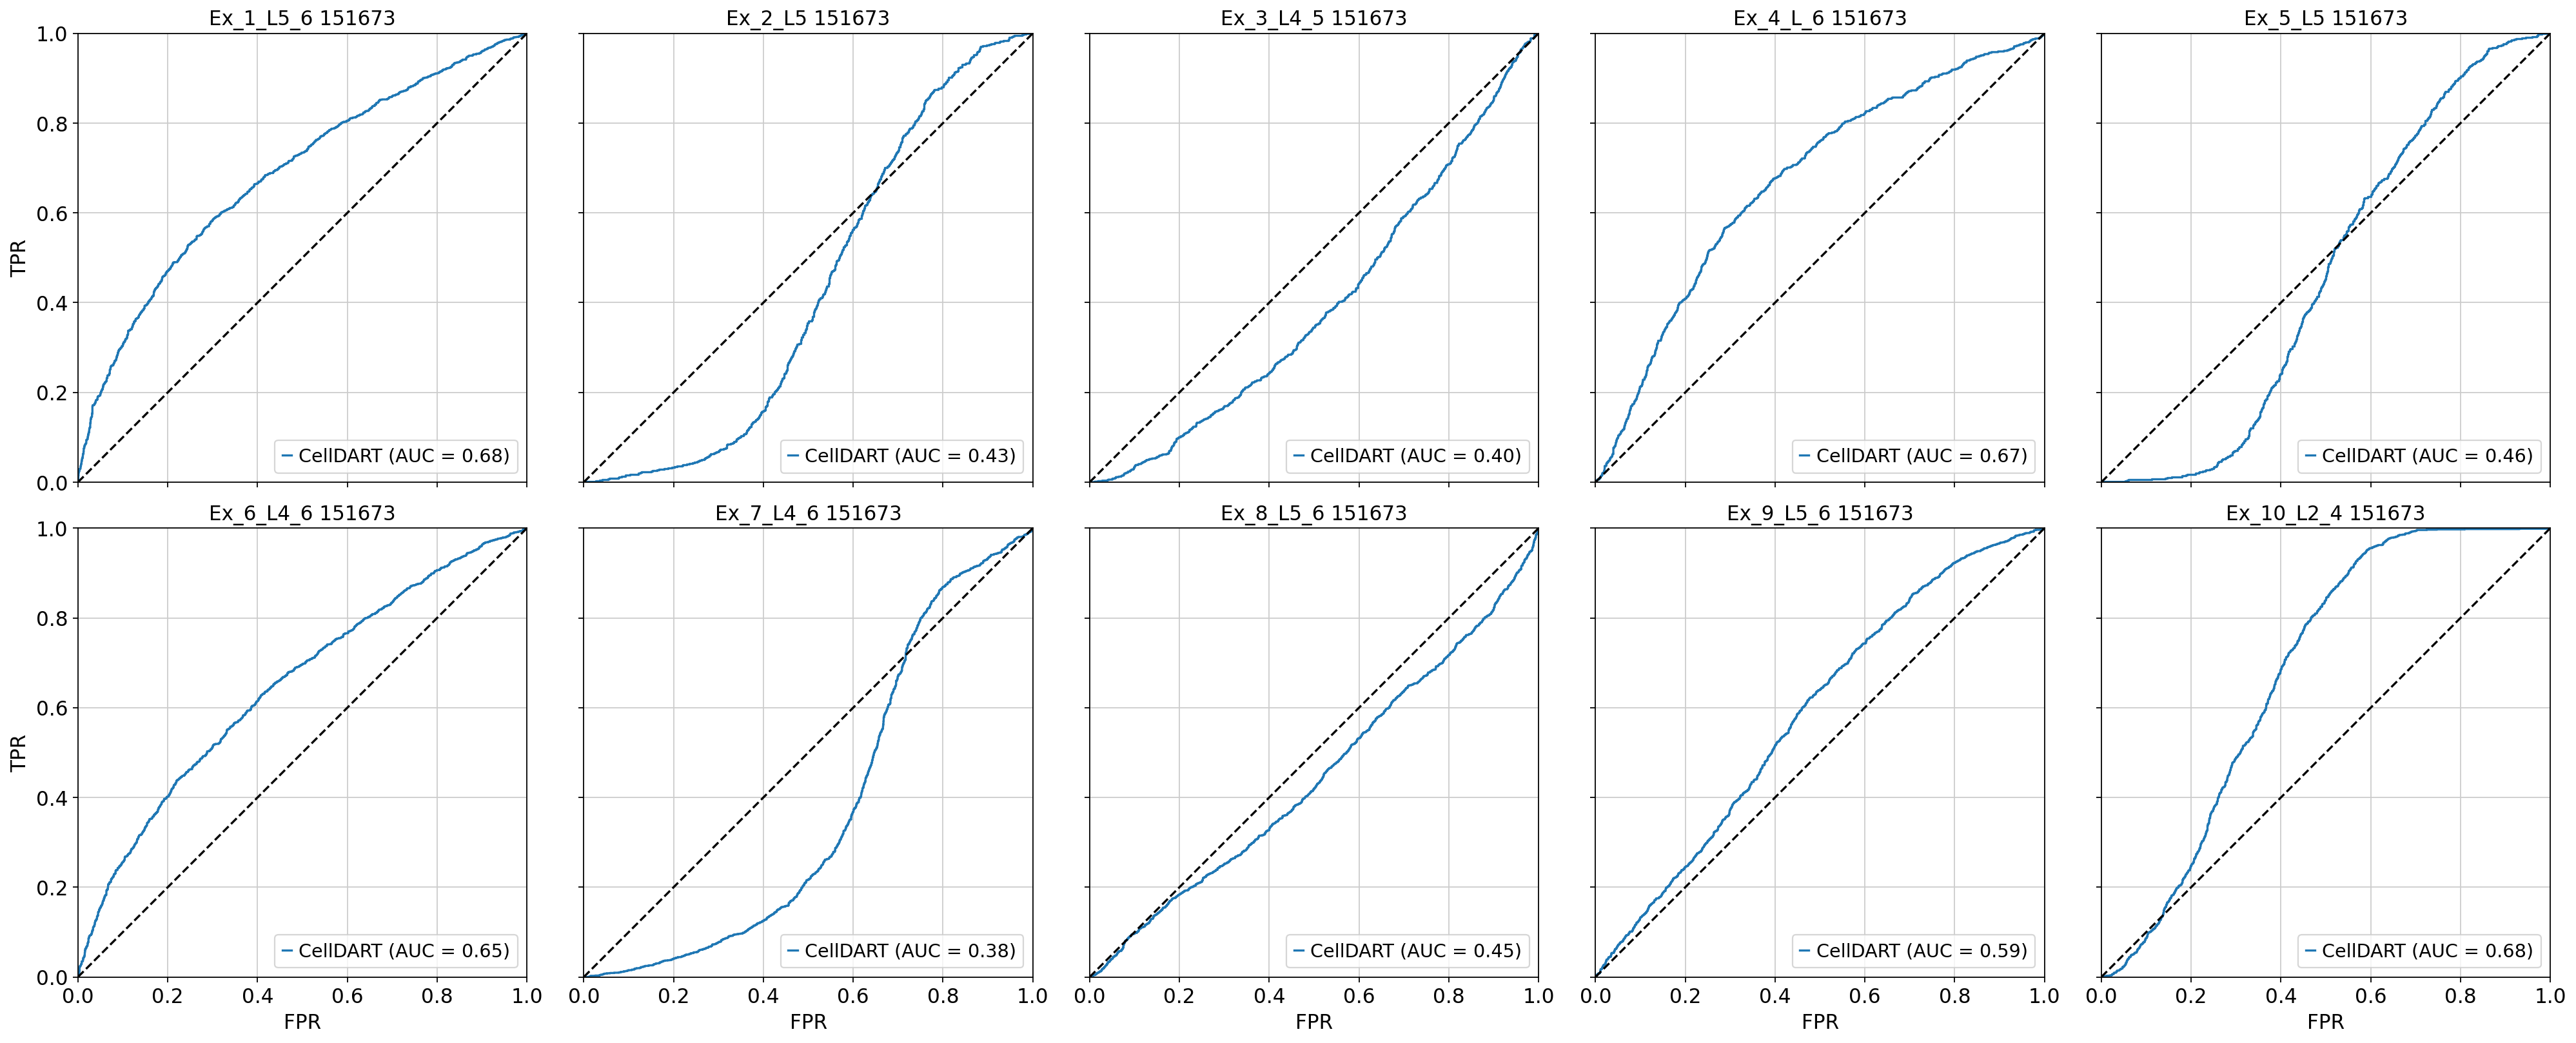

In [149]:

fig, ax = plt.subplots(2, 5, figsize=(25,10), constrained_layout=True, sharex=True, sharey=True)

for i, num in enumerate(numlist):
    plot_roc(num, ax.flat[i])
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls='--', color='k')
    ax.flat[i].set_aspect('equal')
    ax.flat[i].set_xlim([0,1])
    ax.flat[i].set_ylim([0,1])
    
    ax.flat[i].set_title(f'{sc_sub_dict[num]} 151673')

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel('FPR')
    else:
        ax.flat[i].set_xlabel('')
    if  i % 5 == 0:
        ax.flat[i].set_ylabel('TPR')
    else:
        ax.flat[i].set_ylabel('')

/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

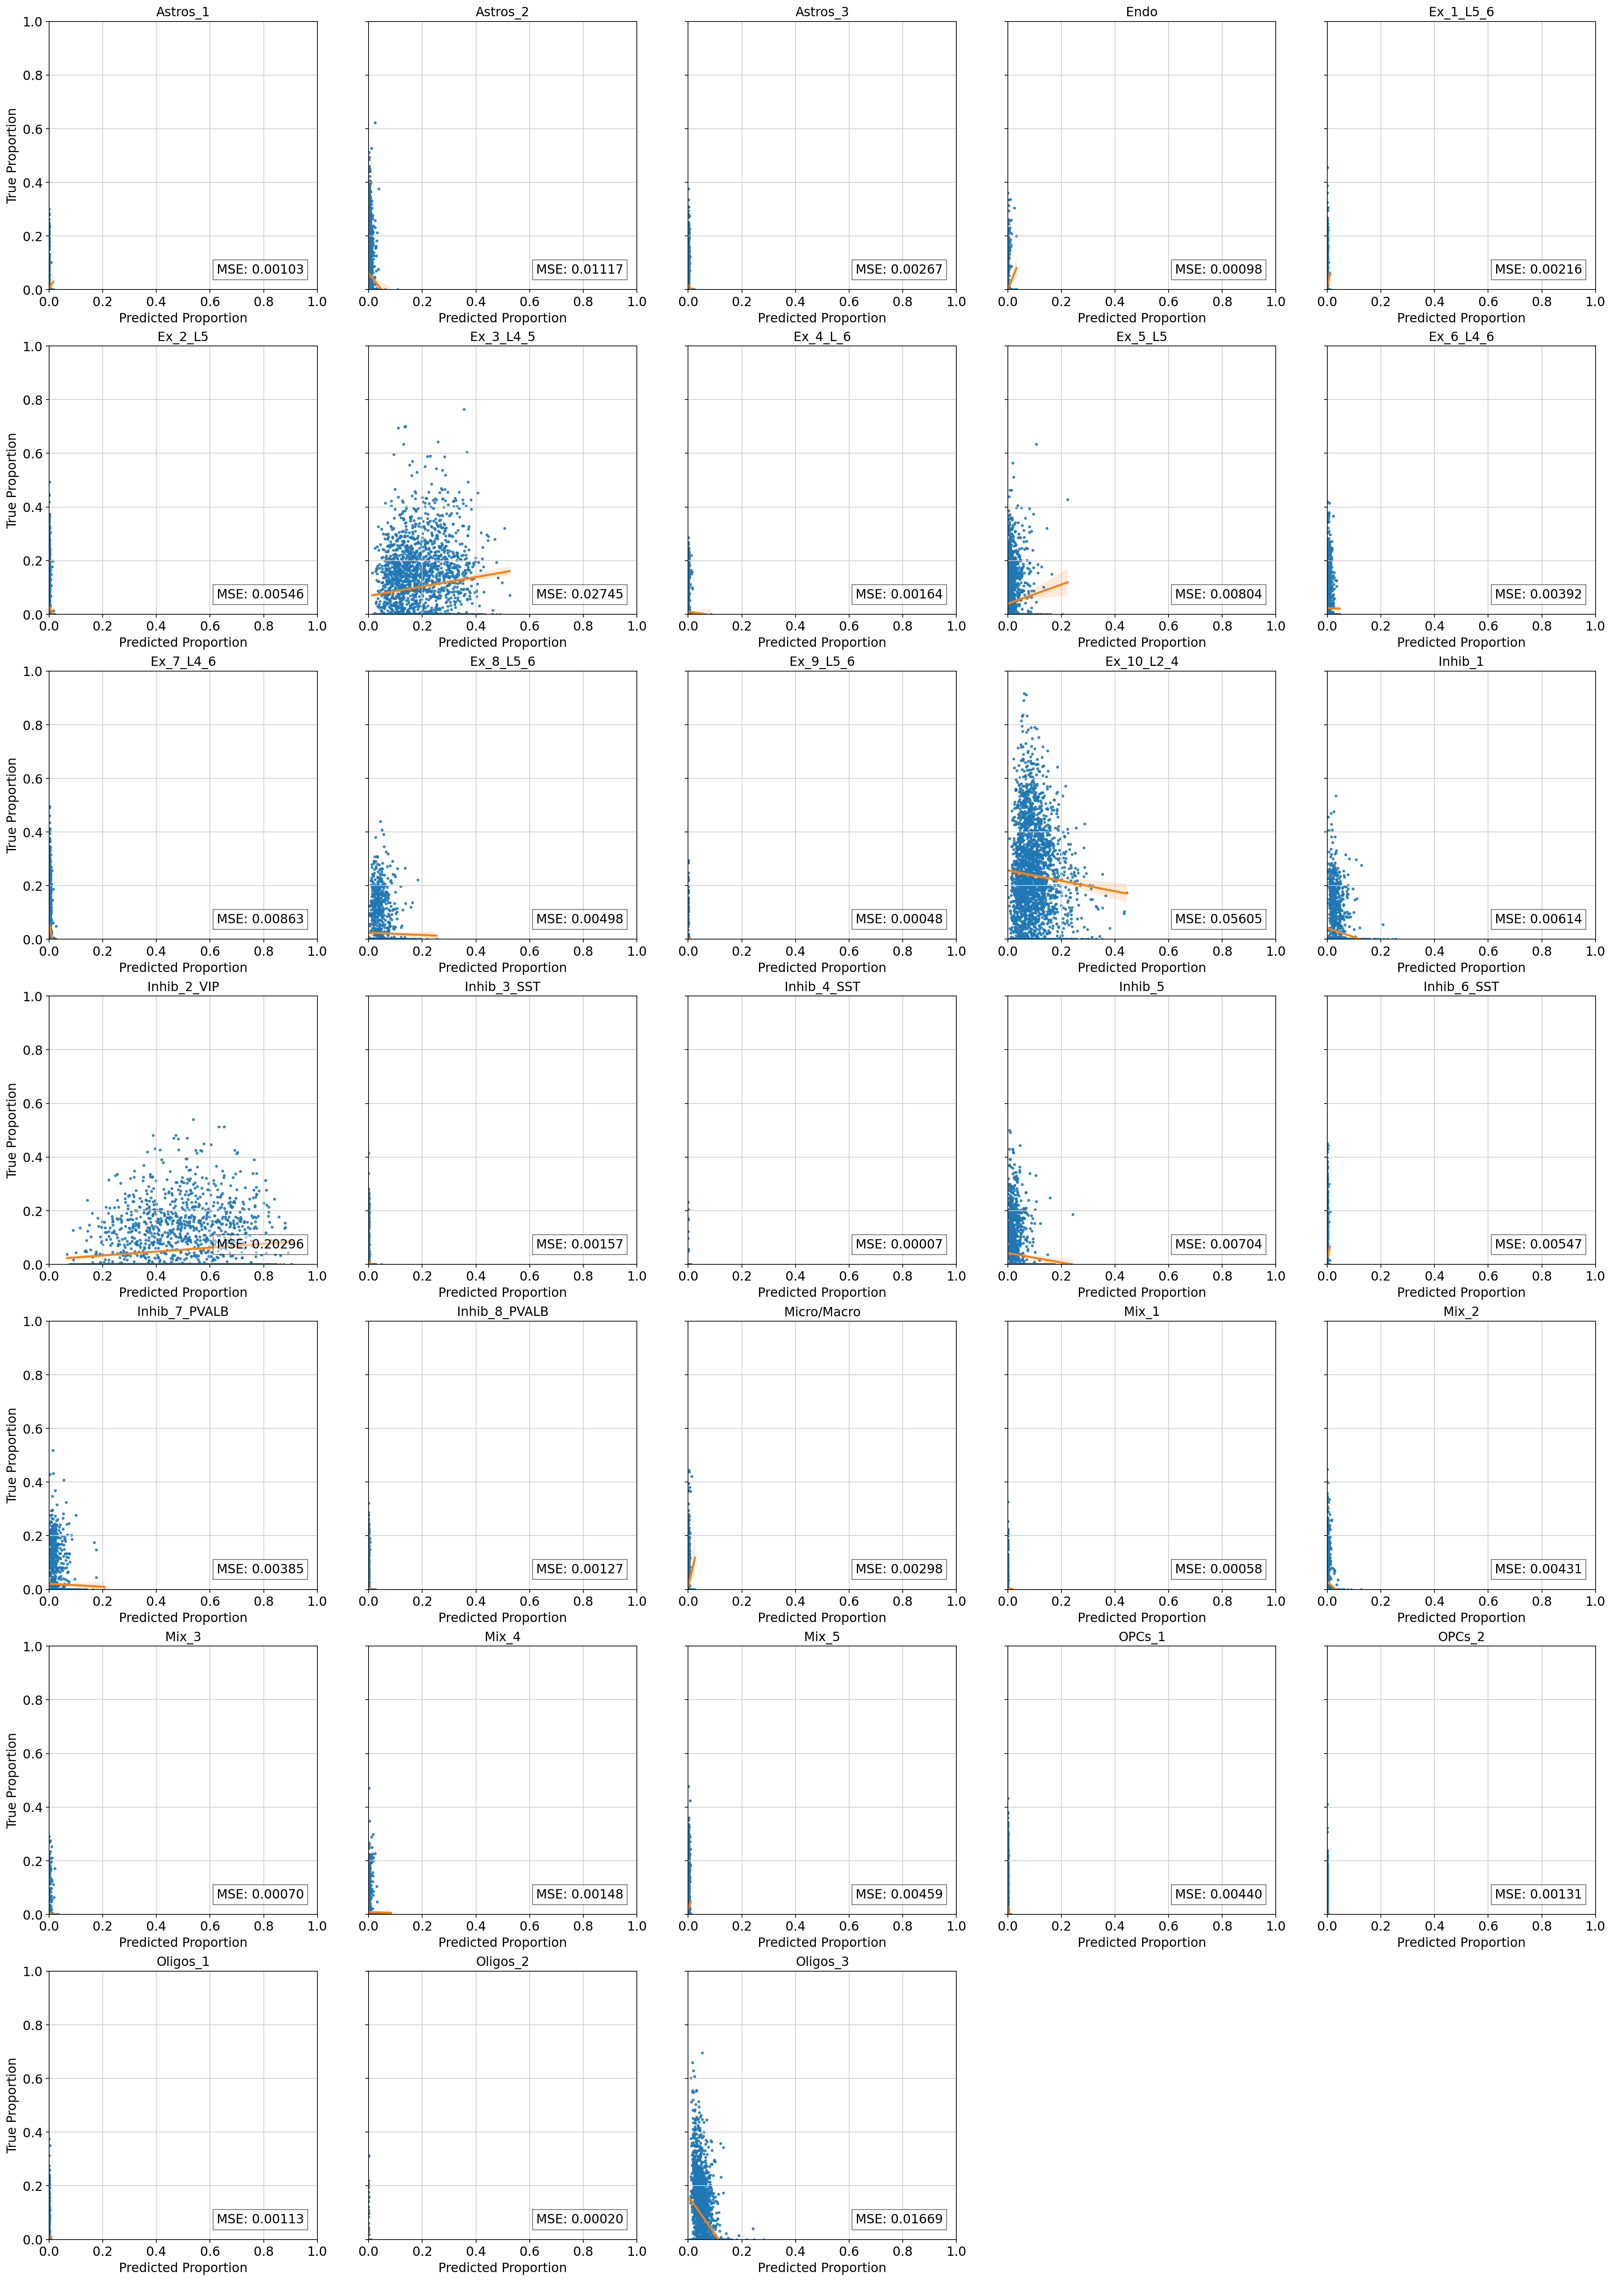

In [150]:
from sklearn.metrics import mean_squared_error

pred_mix = F.softmax(model(torch.Tensor(sc_mix_test_s).to(device)), dim=1).detach().cpu().numpy()

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {'color':'tab:orange'}
scatter_kws = {'s':5}

props = dict(facecolor='w', alpha=0.5)

fig, ax = plt.subplots(nrows, 5, figsize = (25, 5*nrows), constrained_layout=True, sharex=False, sharey=True)
for i, visnum in enumerate(cell_type_nums):    
    sns.regplot(
        pred_mix[:,visnum],
        lab_mix_test[:,visnum], 
        line_kws = line_kws,
        scatter_kws = scatter_kws,
        ax=ax.flat[i]
    ).set_title(sc_sub_dict[visnum])
    ax.flat[i].set_aspect('equal')

    # if i >= len(cell_type_nums) - 5:
    ax.flat[i].set_xlabel('Predicted Proportion')
    # else:
    #     ax.flat[i].set_xlabel('')
    if  i % 5 == 0:
        ax.flat[i].set_ylabel('True Proportion')
    else:
        ax.flat[i].set_ylabel('')
    ax.flat[i].set_xlim([0,1])
    ax.flat[i].set_ylim([0,1])

    textstr = f'MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}'

    # place a text box in upper left in axes coords
    ax.flat[i].text(0.95, 0.05, textstr, transform=ax.flat[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

for i in range(len(cell_type_nums), nrows*5):
    ax.flat[i].axis('off')

plt.show()